# Segment Anything 微调

SAM 全部微调需求的内存是巨大的，没有大显卡的朋友不要跑这一章。

# 一、环境准备

## 1.检查 CUDA 状态

多卡需禁用，或者运行后重启内核。

In [29]:
import torch
import pandas as pd
pd.set_option('display.max_rows', None)  # 设置显示最大行

def check_cuda():
    flag = torch.cuda.is_available()
    if flag:
        print("CUDA可使用")
    else:
        print("CUDA不可用")

    # 获取GPU数量
    ngpu = torch.cuda.device_count()
    print("GPU数量：",ngpu)
    # Decide which device we want to run on
    device = torch.device("cuda:1" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    print("驱动为：",device)
    print("GPU型号： ",torch.cuda.get_device_name(0))


check_cuda()

CUDA可使用
GPU数量： 2
驱动为： cuda:1
GPU型号：  NVIDIA GeForce RTX 3090


## 2.环境超参

In [30]:
from argparse import Namespace
import sys
sys.path.insert(0, '..')

config = Namespace(
    img_size=1024,
    batch_size=2,
    num_workers=2,
    lr=1e-4,
    model_name="vit_b",
    model_cpt_path="../checkpoints/sam/sam_vit_b_01ec64.pth",
    random_prompt=False,
    
    mean=(123.675, 116.28, 103.53),
    std=(58.395, 57.12, 57.375),
)

## 3.可视化方法

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

def trans_ori_comparision(
        idxs, images, masks, ori_dataset,
        points=None, bboxes=None, cls_labels=None,
        mean=None, std=None, max_show_num=1,
):
    assert images is not None and masks is not None and idxs is not None, "image, label, id 不可缺少"
    assert max_show_num <= idxs.shape[0], "展示长度大于图片集长度"

    # tensor -> numpy
    idxs = idxs.detach().cpu().numpy()
    imgs_arr = images.detach().cpu().permute(0, 2, 3, 1).numpy()
    masks_arr = masks.detach().cpu().permute(0, 2, 3, 1).numpy()
    masks_arr = masks_arr > 0

    if points is not None or bboxes is not None:

        cls_labels_arr = cls_labels.detach().cpu().numpy()

        if points is not None:
            points_arr = points.detach().cpu().numpy()

        if bboxes is not None:
            bboxs_arr = bboxes.detach().cpu().numpy()

    if mean is not None and std is not None:
        imgs_arr = (imgs_arr * std + mean).astype(np.uint8)

    for i in range(max_show_num):
        idx = idxs[i][0]
        img_arr = imgs_arr[i]
        mask_arr = masks_arr[i].squeeze()

        # 创建一个包含两个子图的图形
        fig, axs = plt.subplots(1, 2, figsize=(20, 10))

        # 显示第一个图像
        axs[0].imshow(img_arr)
        axs[0].axis('on')
        show_mask(mask_arr, axs[0])

        # 显示第二个图像
        img_ori, mask_ori, prompt = ori_dataset.get(idx)
        img_ori = np.array(img_ori)
        mask_ori = np.array(mask_ori) > 0
        point_ori = prompt.get('point', None)
        bbox_ori = prompt.get('bbox', None)

        axs[1].imshow(img_ori)
        axs[1].axis('on')
        show_mask(mask_ori, axs[1])

        # 统一画线
        if points is not None or bboxes is not None:
            cls_label_arr = cls_labels_arr[i]
            if points is not None:
                point_arr = points_arr[i]
                show_points(point_arr, cls_label_arr, axs[0])
                show_points(point_ori, cls_label_arr, axs[1])

            if bboxes is not None:
                bbox_arr = bboxs_arr[i]
                for bbox_1, bbox_2 in zip(bbox_arr, bbox_ori):
                    show_box(bbox_1, axs[0])
                    show_box(bbox_2, axs[1])

        # 显示图形
        plt.show()

# 二、数据准备

## 1.定义数据增强方式

In [32]:
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2


def create_transform():
    train_transforms = A.Compose(
        [
            A.OneOf([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
            ]),
            A.LongestMaxSize(
                max_size=config.img_size, p=1.0
            ),
            A.Normalize(
                mean=config.mean,
                std=config.std,
                max_pixel_value=1.0,
                p=1.0
            ),
            A.PadIfNeeded(
                min_height=config.img_size, min_width=config.img_size, 
                border_mode=cv2.BORDER_CONSTANT,
                value=0, p=1.0
            ),
            ToTensorV2(p=1),
        ],
        p=1.0,
        keypoint_params=A.KeypointParams(format='xy'),
        bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']),
    )
    val_transforms = A.Compose(
        [
            A.LongestMaxSize(
                max_size=config.img_size, p=1.0
            ),
            A.Normalize(
                mean=config.mean,
                std=config.std,
                max_pixel_value=1.0,
                p=1.0
            ),
            A.PadIfNeeded(
                min_height=config.img_size, min_width=config.img_size, 
                border_mode=cv2.BORDER_CONSTANT,
                value=0, p=1.0
            ),
            ToTensorV2(p=1),
        ],
        keypoint_params=A.KeypointParams(format='xy'),
        bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']),
    )
    return train_transforms, val_transforms

## 2.定义 dataset 和 dataloader

这里使用 ISIC 的皮肤病变数据集，可以通过：https://challenge.isic-archive.com/data/ 进行下载，只需要改变下面代码中的路径指向自己的数据集就可以。

In [33]:
from custom.sam.datasets.isic2016 import ISIC2016Dataset
from pathlib import Path
import torch
import torch.utils
import torchvision

from torch.utils.data import DataLoader, ConcatDataset


def create_dataset():
    train_imgs = [
        str(x) for x in Path("/home/zijieshen/new_disk/datasets/ISIC2016/P1/Train").rglob("*.jpg")
        if "checkpoint" not in str(x)
    ][:100]
    val_imgs = [
        str(x) for x in Path("/home/zijieshen/new_disk/datasets/ISIC2016/P1/Val").rglob("*.jpg")
        if "checkpoint" not in str(x)
    ][:20]
    train_ts, val_ts = create_transform()
    train_ds = ISIC2016Dataset(
        img_files=train_imgs, transforms=train_ts, 
        use_bbox=True, use_point=True, use_random=config.random_prompt
    )
    val_ds = ISIC2016Dataset(
        img_files=val_imgs, transforms=val_ts, 
        use_bbox=True, use_point=True, use_random=False
    )
    return train_ds, val_ds


def create_dataloader(train_ds=None, val_ds=None):
    if train_ds is None or val_ds is None:
        train_ds, val_ds = create_dataset()

    train_dl = DataLoader(
        train_ds, batch_size=config.batch_size,
        shuffle=True, num_workers=config.num_workers
    )
    val_dl = DataLoader(
        val_ds, batch_size=config.batch_size,
        shuffle=False, num_workers=config.num_workers
    )
    return train_dl, val_dl

train_dataset, val_dataset = create_dataset()
train_dataloader, val_dataloader = create_dataloader(train_dataset, val_dataset)


## 3.检查数据

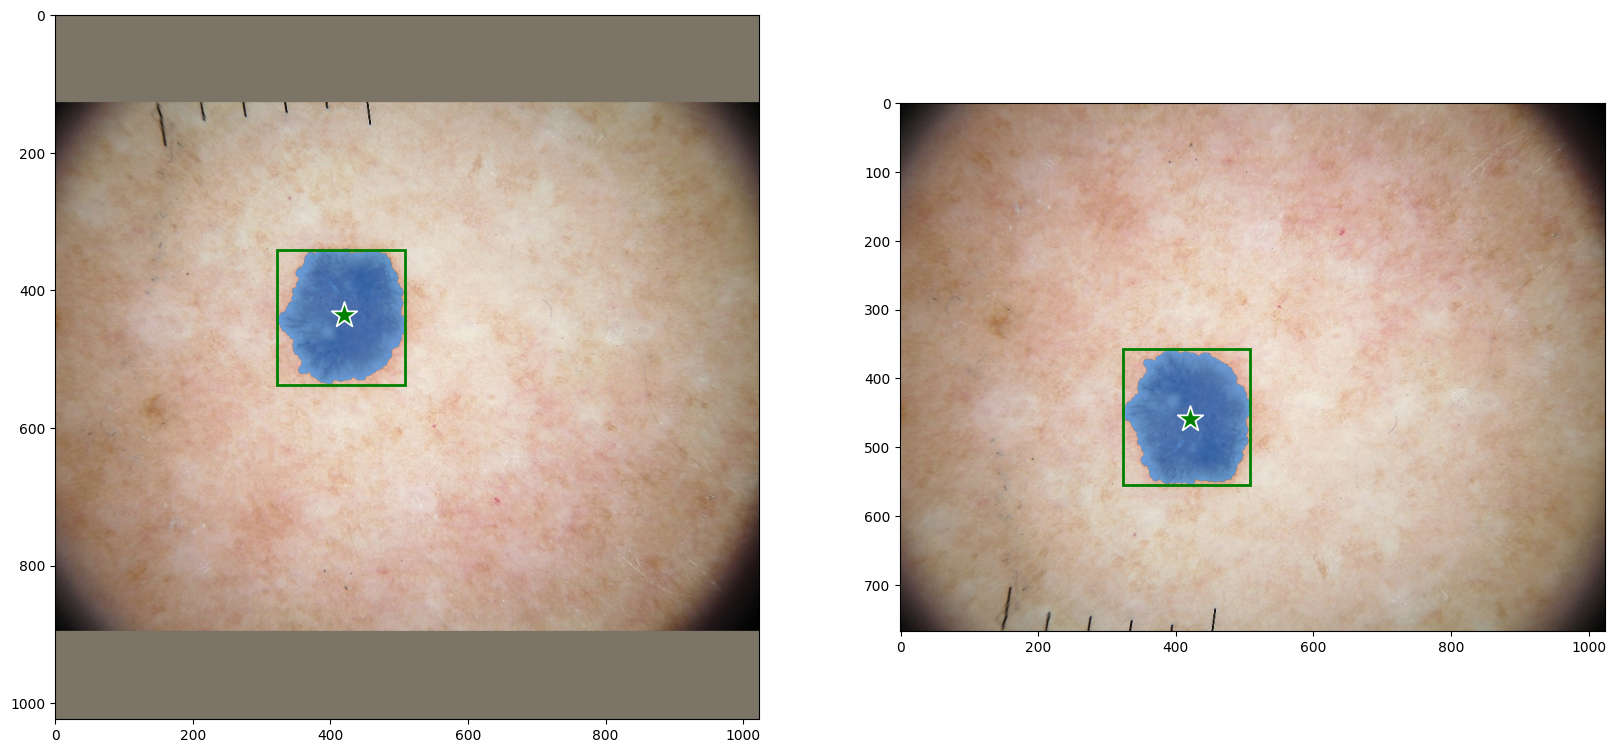

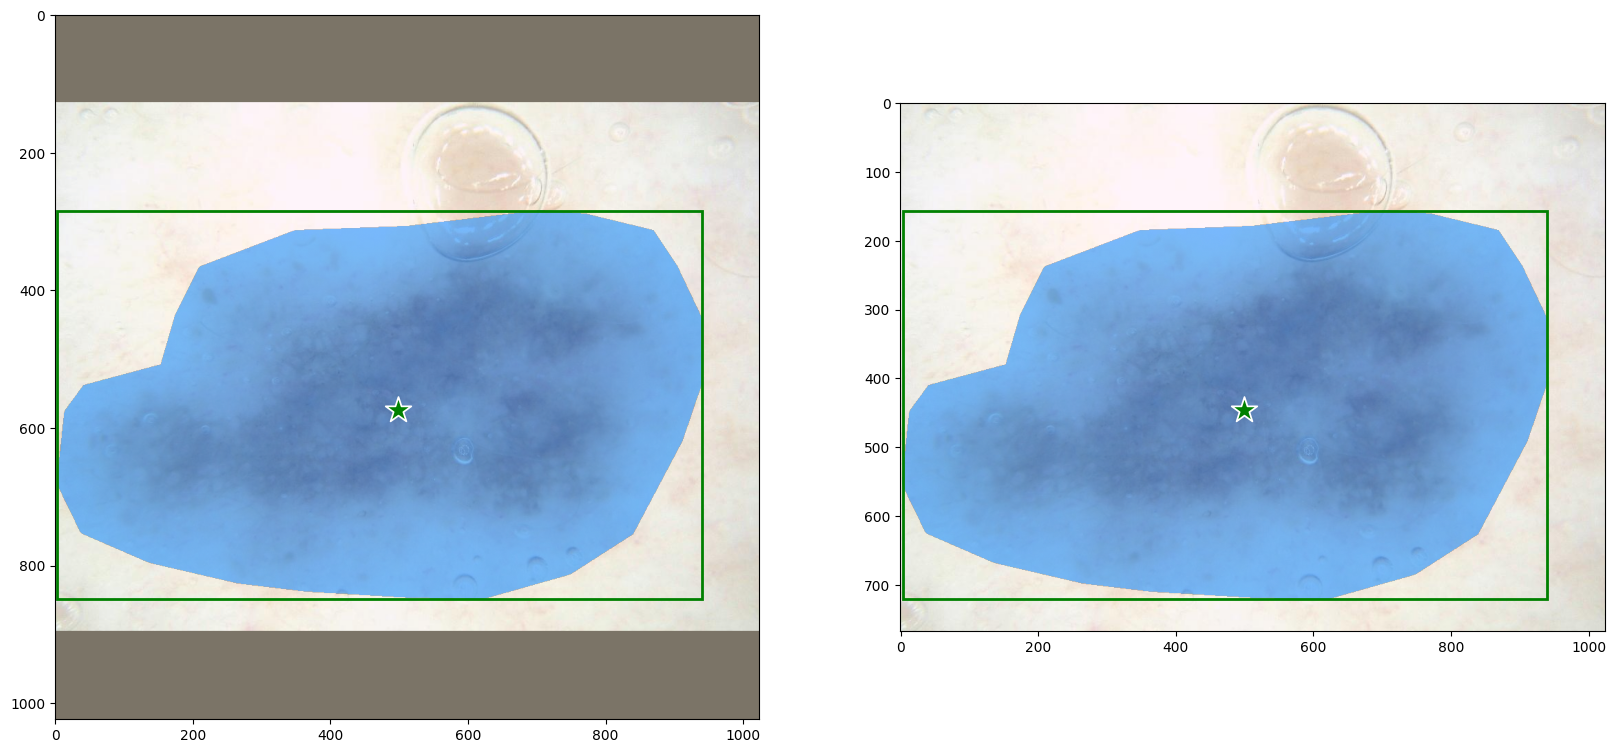

In [34]:
import matplotlib.pyplot as plt
import numpy as np

for batch in train_dataloader:
    
    images = batch.get('image', None)
    masks = batch.get('mask', None)
    idxs = batch.get('idx', None)

    points = batch.get('keypoints', None)
    bboxes = batch.get('bboxes', None)
    cls_labels = batch.get('cls_labels', None)

    trans_ori_comparision(
        idxs, images, masks, train_dataset, points, bboxes, cls_labels,
        mean=config.mean, std=config.std, max_show_num=2
    )
   
    break

# 三、训练准备

## 1.定义模型

### 1.定义模型

In [35]:
from segment_anything import sam_model_registry


sam = sam_model_registry[config.model_name](checkpoint=config.model_cpt_path)

assert sam.image_encoder.img_size == config.img_size, "图像大小不一致"

### 2.参数统计 (可选)

In [36]:
mdp_num = sum(p.numel() for p in sam.mask_decoder.parameters()) 
iep_num = sum(p.numel() for p in sam.image_encoder.parameters()) 
pdp_num = sum(p.numel() for p in sam.prompt_encoder.parameters()) 

print(
    f"mask_decoder parameter number: {mdp_num} \n",
    f"image_encoder parameter number: {iep_num} \n",
    f"prompt_encoder parameter number: {pdp_num} \n",
    f"total parameter number: {mdp_num + iep_num + pdp_num}"
)

mask_decoder parameter number: 4058340 
 image_encoder parameter number: 89670912 
 prompt_encoder parameter number: 6220 
 total parameter number: 93735472


## 2.定义 PEFT，此处为 Lora

### 1.选择需要 PEFT 的层

In [37]:
target_modules = [
    "image_encoder.blocks.{}.attn.qkv".format(i) for i in range(12)
]

### 2.设置 lora，并得到 lora 模型

In [38]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(target_modules=target_modules, r=2)
sam_lora = get_peft_model(sam, lora_config)
print(sam_lora)

PeftModel(
  (base_model): LoraModel(
    (model): Sam(
      (image_encoder): ImageEncoderViT(
        (patch_embed): PatchEmbed(
          (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (blocks): ModuleList(
          (0-11): 12 x Block(
            (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (attn): Attention(
              (qkv): lora.Linear(
                (base_layer): Linear(in_features=768, out_features=2304, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=2, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=2, out_features=2304, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
      

### 3.选择参与梯度下降的层

PEFT 包会将原网络中的所有层冻住，只有 PEFT 层处于激活状态，所以如果需要训练原网络的其他层，这里需要进行手动解冻。（如果只需要 PEFT，则跳过这一节）

这里我们只希望训练 Lora 和 mask_decoder 部分，所以只需要手动解冻 mask_decoder 层。

In [39]:
for param in sam_lora.base_model.model.mask_decoder.parameters():
    param.requires_grad = False


print(f"lora sam parameter number: {sum(p.numel() for p in sam_lora.parameters())}")

lora sam parameter number: 93809200


### 4.检查参数梯度下降的层

In [40]:
for name, param in sam_lora.named_parameters():
    if param.requires_grad:
        print(name)

base_model.model.image_encoder.blocks.0.attn.qkv.lora_A.default.weight
base_model.model.image_encoder.blocks.0.attn.qkv.lora_B.default.weight
base_model.model.image_encoder.blocks.1.attn.qkv.lora_A.default.weight
base_model.model.image_encoder.blocks.1.attn.qkv.lora_B.default.weight
base_model.model.image_encoder.blocks.2.attn.qkv.lora_A.default.weight
base_model.model.image_encoder.blocks.2.attn.qkv.lora_B.default.weight
base_model.model.image_encoder.blocks.3.attn.qkv.lora_A.default.weight
base_model.model.image_encoder.blocks.3.attn.qkv.lora_B.default.weight
base_model.model.image_encoder.blocks.4.attn.qkv.lora_A.default.weight
base_model.model.image_encoder.blocks.4.attn.qkv.lora_B.default.weight
base_model.model.image_encoder.blocks.5.attn.qkv.lora_A.default.weight
base_model.model.image_encoder.blocks.5.attn.qkv.lora_B.default.weight
base_model.model.image_encoder.blocks.6.attn.qkv.lora_A.default.weight
base_model.model.image_encoder.blocks.6.attn.qkv.lora_B.default.weight
base_m

## 3.定义 loss、optimizer、lr_schedulaer、metrics_dict

这里和前面的不同地方在于，Adam 只接收需要训练的参数，前面的参数是全部参与训练，而这里是部分，所以需要进行过滤。

In [41]:
import torch
from torchkeras.metrics import IOU
from torchkeras.kerasmodel import KerasModel
from custom.loss import MixedLoss, DiceLoss

optim = torch.optim.Adam(filter(
    lambda p: p.requires_grad, sam_lora.parameters()
), lr=config.lr)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, T_max=8, eta_min=1e-6
)
metrics = {
    "iou": IOU(num_classes=1)
}


## 4.定义 torchkeras 模型

In [42]:
model = KerasModel(
    sam_lora, loss_fn=MixedLoss(0.5), optimizer=optim,
    lr_scheduler=lr_scheduler, metrics_dict=metrics
)

## 5.定义训练 StepRunner

In [43]:
from importlib import reload
from torchkeras import kerasmodel, pbar
from custom.sam.step.peft_step import SamPeftStepRunner

# reload(kerasmodel)
# reload(pbar)

kerasmodel.KerasModel.StepRunner = SamPeftStepRunner

# 四、训练

## 1.Wandb记录、VisDisplay展示

In [44]:
from importlib import reload
from torchkeras import kerasmodel, kerascallbacks
reload(kerascallbacks)

from torchkeras.kerascallbacks import WandbCallback
from torchkeras.kerascallbacks import VisDisplay


def display_fn(model):
    from matplotlib import pyplot as plt
    batch = next(iter(val_dataloader))

    with torch.no_grad():

        images = batch.get('image', None).cuda()
        idxs = batch.get('idx', None).cuda()

        points = batch.get('keypoints', None).cuda()
        bboxes = batch.get('bboxes', None).cuda()
        cls_labels = batch.get('cls_labels', None).cuda()

        if points is not None:
            points_coords = (points, cls_labels)

        features = model.net.image_encoder(images)

        sparse_embeddings, dense_embeddings = model.net.base_model.model.prompt_encoder(
            points=points_coords if points is not None else points,
            boxes=bboxes,
            masks=None
        )

        low_res_masks, iou_predictions = model.net.base_model.model.mask_decoder(
            image_embeddings=features,
            image_pe=model.net.base_model.model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False
        )

        preds = model.net.base_model.model.postprocess_masks(
            low_res_masks, images.shape[-2:], images.shape[-2:] 
        )

        preds = preds > 0

        trans_ori_comparision(
            idxs, images, preds, val_dataset, points, bboxes, cls_labels, 
            mean=config.mean, std=config.std, max_show_num=2
        )


wandb_cb = WandbCallback(
    project='sam',
    config=config.__dict__,
    name=None,
    save_code=True,
    save_ckpt=True,
)

visdis_cb = VisDisplay(display_fn, model = model, init_display=False)


## 2.单卡训练

<<<<<< ⚡️ cuda is used >>>>>>


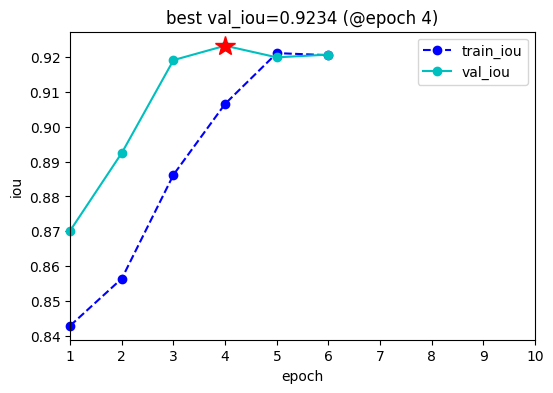

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: zijie-shen795 (uestc-cd). Use `wandb login --relogin` to force relogin


Output()

KeyboardInterrupt: 

In [45]:

dfhistory=model.fit(
    train_data=train_dataloader,
    val_data=val_dataloader,
    epochs=40,
    ckpt_path='checkpoint.pt',
    patience=5,
    monitor="val_iou",
    mode="max",
    mixed_precision='no',
    callbacks = [wandb_cb,visdis_cb],
    plot=True,
    cpu=False,
    quiet=True,
)
